In [1]:
"""
do gini score on all categories then go with lowest gini impurity score and repeat.
impurity is worse: less splits.
random forest - each tree randomly looks at 2 columns and compares. prevents overfitting (learning too much). predictions from all trees is the consensus of the forest.
"""

'\ndo gini score on all categories then go with lowest gini impurity score and repeat.\nimpurity is worse: less splits.\nrandom forest - each tree randomly looks at 2 columns and compares. prevents overfitting (learning too much). predictions from all trees is the consensus of the forest.\n'

In [2]:
# Import our libraries 

# Pandas and numpy for data wrangling
import pandas as pd
import numpy as np

# Seaborn / matplotlib for visualization 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Import the trees from sklearn
from sklearn import tree

# Helper function to split our data
from sklearn.model_selection import train_test_split

# Helper fuctions to evaluate our model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score 

# Helper function for hyper-parameter turning.
from sklearn.model_selection import GridSearchCV

# Import our Decision Tree
from sklearn.tree import DecisionTreeClassifier 

# Import our Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Library for visualizing our tree
# If you get an error, run 'pip install graphviz' in your terminal
import graphviz 

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Main Steps when building a Machine Learning Model. 
1. Inspect and explore data.
2. Select and engineer features.
3. Build and train model.
4. Evaluate model.

# #1 Inspect and explore data.

In [3]:
df = pd.read_csv('data/titanic.csv')
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.red

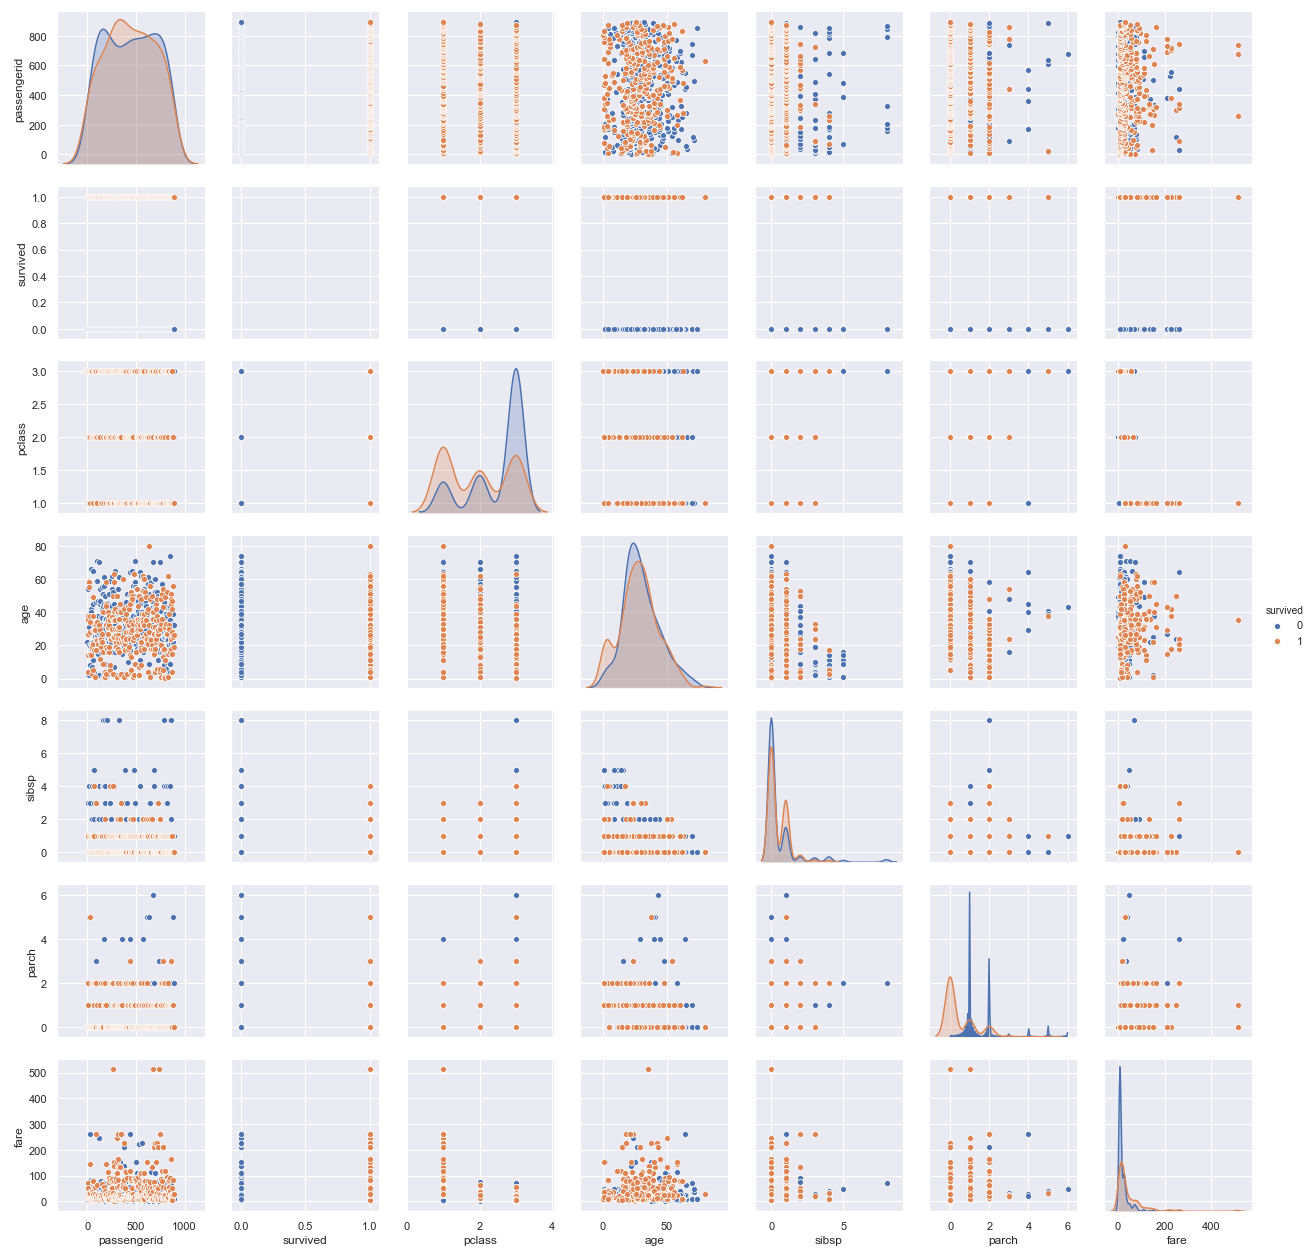

In [4]:
sns.pairplot(df, hue='survived');

In [5]:
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

# #2 Select and engineer features.
1. Convert to numerical values if need be by using `pd.get_dummies()`
1. Select our features
1. Define our `X` and `y`
1. Split into trainig and testing features

In [6]:
# 1. Convert to numerical values if need be by using `pd.get_dummies()`
df = pd.get_dummies(df, columns=['sex', 'pclass', 'embarked'], drop_first=True)

In [7]:
df.head()

,passengerid,survived,name,age,sibsp,parch,ticket,fare,cabin,sex_male,pclass_2,pclass_3,embarked_Q,embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [8]:
selected_features = ['fare', 'age',  'sex_male', 'pclass_2', 'pclass_3',  'sibsp', 'parch', 'embarked_Q','embarked_S']

# Sklearn will throw an error if you have literal NAN's 
# You have to fill it with a value that is outside of the range of its current value.
df['age'] = df['age'].fillna(-999)

X = df[selected_features]

y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

print('Lenght of our Training data:', X_train.shape, '\nLength of our Testing data:', y_test.shape)

Lenght of our Training data: (712, 9) 
Length of our Testing data: (179,)


# #3 Build and train model.
1. For our first pass, initialize our model with `max_depth=2`.
2. Fit our model with our training data. 
3. Make predictions of our testing data. 
4. Evaluate our model using accuracy, precision, recall, and f1 scores. 
5. Visualize our Decision Tree using provided code. 


In [9]:
from sklearn.tree import DecisionTreeClassifier 

model = DecisionTreeClassifier(max_depth=2)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)


# Calculate predicted probabilities
y_pred_proba = model.predict_proba(X_test)

# # Keep only the proba for True
y_pred_proba = y_pred_proba[:,1]

# # Compute auc score
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)

print('AUC Score: %f' % auc)

Accuracy Score: 0.832402
Precision Score: 0.750000
Recall Score: 0.774194
F1 Score: 0.761905
AUC Score: 0.868004


# Visualize your decision tree. 
* If you get an error, you may need to install the graphviz library.
* Run this command in your terminal to install the graphviz library. 
    * `conda install python-graphviz`
* If that does not work, then try installing the library using pip. 
    * `pip install graphviz`


In [10]:
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=selected_features,
                     class_names=['died','survived'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

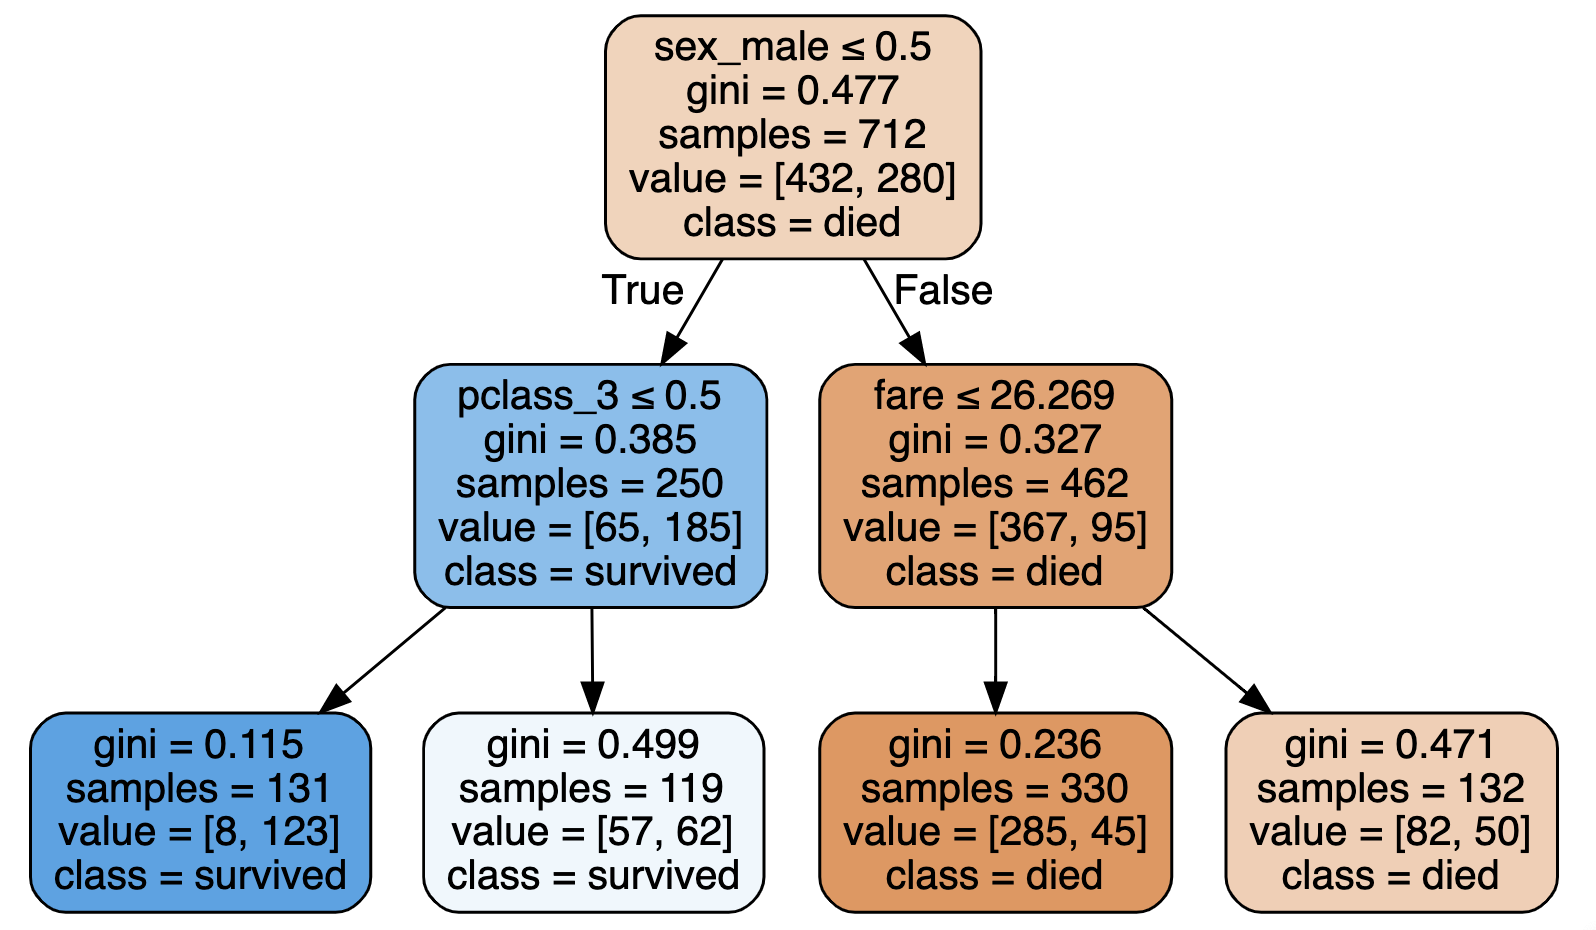

In [11]:
from IPython.display import Image
Image("images/decision-tree.png")

# Lets increase our tree max_depth


In [12]:
model = tree.DecisionTreeClassifier(max_depth=4)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)


# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)


# dot_data = tree.export_graphviz(model, out_file=None, 
#                      feature_names=selected_features,
#                      class_names=['died','survived'],
#                      filled=True, rounded=True,  
#                      special_characters=True)  

# graph = graphviz.Source(dot_data)  
# graph

Accuracy Score: 0.860335
Precision Score: 0.784615
Recall Score: 0.822581
F1 Score: 0.803150
AUC Score: 0.899366


# Lets Increase max_depth even further...
* What happens to our evaluation scores when we increase max_depth to be 100?
* What reason do you think the changes in scores happened..?

In [13]:
model = tree.DecisionTreeClassifier(max_depth=100)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)


# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)


# dot_data = tree.export_graphviz(model, out_file=None, 
#                      feature_names=selected_features,
#                      class_names=['died','survived'],
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph


Accuracy Score: 0.787709
Precision Score: 0.642857
Recall Score: 0.870968
F1 Score: 0.739726
AUC Score: 0.817963


In [14]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Picking the right parameters...

# Parameter tuning of your Decision Tree using GridSearch
Below is a list of all the parameters you can adjust within a Decision Tree.  Instead of having to manually go and train N new models with every permutation, you can use the GridSearch function.

```python
tree.DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0,
)


Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

min_samples_split : int or float, default=2
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a fraction and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.

    .. versionchanged:: 0.18
       Added float values for fractions.

min_samples_leaf : int or float, default=1
    The minimum number of samples required to be at a leaf node.
    A split point at any depth will only be considered if it leaves at
    least ``min_samples_leaf`` training samples in each of the left and
    right branches.  This may have the effect of smoothing the model,
    especially in regression.

    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a fraction and
      `ceil(min_samples_leaf * n_samples)` are the minimum
      number of samples for each node.

    .. versionchanged:: 0.18
       Added float values for fractions.

min_weight_fraction_leaf : float, default=0.0
    The minimum weighted fraction of the sum total of weights (of all
    the input samples) required to be at a leaf node. Samples have
    equal weight when sample_weight is not provided.

max_features : int, float or {"auto", "sqrt", "log2"}, default=None
    The number of features to consider when looking for the best split:

        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

    Note: the search for a split does not stop until at least one
    valid partition of the node samples is found, even if it requires to
    effectively inspect more than ``max_features`` features.

random_state : int, RandomState instance, default=None
    Controls the randomness of the estimator. The features are always
    randomly permuted at each split, even if ``splitter`` is set to
    ``"best"``. When ``max_features < n_features``, the algorithm will
    select ``max_features`` at random at each split before finding the best
    split among them. But the best found split may vary across different
    runs, even if ``max_features=n_features``. That is the case, if the
    improvement of the criterion is identical for several splits and one
    split has to be selected at random. To obtain a deterministic behaviour
    during fitting, ``random_state`` has to be fixed to an integer.
    See :term:`Glossary <random_state>` for details.

max_leaf_nodes : int, default=None
    Grow a tree with ``max_leaf_nodes`` in best-first fashion.
    Best nodes are defined as relative reduction in impurity.
    If None then unlimited number of leaf nodes.

min_impurity_decrease : float, default=0.0
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.

    The weighted impurity decrease equation is the following::

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

    where ``N`` is the total number of samples, ``N_t`` is the number of
    samples at the current node, ``N_t_L`` is the number of samples in the
    left child, and ``N_t_R`` is the number of samples in the right child.

    ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
    if ``sample_weight`` is passed.

    .. versionadded:: 0.19

min_impurity_split : float, default=0
    Threshold for early stopping in tree growth. A node will split
    if its impurity is above the threshold, otherwise it is a leaf.

    .. deprecated:: 0.19
       ``min_impurity_split`` has been deprecated in favor of
       ``min_impurity_decrease`` in 0.19. The default value of
       ``min_impurity_split`` has changed from 1e-7 to 0 in 0.23 and it
       will be removed in 0.25. Use ``min_impurity_decrease`` instead.

class_weight : dict, list of dict or "balanced", default=None
    Weights associated with classes in the form ``{class_label: weight}``.
    If None, all classes are supposed to have weight one. For
    multi-output problems, a list of dicts can be provided in the same
    order as the columns of y.

    Note that for multioutput (including multilabel) weights should be
    defined for each class of every column in its own dict. For example,
    for four-class multilabel classification weights should be
    [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of
    [{1:1}, {2:5}, {3:1}, {4:1}].

    The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed
    through the fit method) if sample_weight is specified.

presort : deprecated, default='deprecated'
    This parameter is deprecated and will be removed in v0.24.

    .. deprecated:: 0.22

ccp_alpha : non-negative float, default=0.0
    Complexity parameter used for Minimal Cost-Complexity Pruning. The
    subtree with the largest cost complexity that is smaller than
    ``ccp_alpha`` will be chosen. By default, no pruning is performed. See
    :ref:`minimal_cost_complexity_pruning` for details.

    .. versionadded:: 0.22
```

[Tips on how to customize / set the paramters in the decision tree.](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)

* Visualise your tree as you are training by using the export function. Use max_depth=3 as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.

In [15]:
from sklearn.model_selection import GridSearchCV

# The params is a dictionary.  
# Where the keys are the parameter, 
# and the values are lists of parameter settings to try as values.
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 7, 100], 
    'min_samples_split': [2, 10, 20, 100],
    'min_samples_leaf': [1, 10, 20, 30],
         }

# Pass in an empty Decision Tree (empty excluding the random_state).
# The parameter dictionary
# and the scoring you want to optimize for. 
grid_search_cv =  GridSearchCV( 
    estimator = DecisionTreeClassifier(), 
    param_grid = params, 
    scoring = 'f1')


# Now, with one easy command, fit all combination of trees. 
grid_search_cv.fit(X_train, y_train)

# Print the best parameters it found
print(grid_search_cv.best_params_)

# This command gives you the best tree
model = grid_search_cv.best_estimator_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


### These are all the scoring functions you can optimize for

In [16]:
import sklearn
for i in sklearn.metrics.SCORERS.keys():
    print(i)

explained_variance
r2
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_squared_error
neg_mean_squared_log_error
median_absolute_error
mean_absolute_error
mean_squared_error
accuracy
roc_auc
average_precision
log_loss
neg_log_loss
adjusted_rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted


# Now lets evaluate our best model

In [17]:
# Now lets evaluate our model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)

# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)

Accuracy Score: 0.877095
Precision Score: 0.870370
Recall Score: 0.758065
F1 Score: 0.810345
AUC Score: 0.881514


# Visualize our best tree.

In [18]:
# dot_data = tree.export_graphviz(model, out_file=None, 
#                      feature_names=selected_features,
#                      class_names=['died','survived'],
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph

# Interpreting the results using feature_importance

In [19]:
# Now lets look at our feature importances
my_dict = {'feature_importance': model.feature_importances_,
           'feature':selected_features }
feature_imp = pd.DataFrame.from_dict( my_dict ).sort_values('feature_importance', ascending=False)
feature_imp

,feature_importance,feature
2,0.516137,sex_male
0,0.172250,fare
4,0.121352,pclass_3
1,0.085694,age
6,0.040531,parch
5,0.039151,sibsp
7,0.018123,embarked_Q
8,0.006763,embarked_S
3,0.000000,pclass_2


# Now onto Random Forests...

In [20]:
# Initialize an empty Random Forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

# Now lets evaluate our model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)

# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)

Accuracy Score: 0.810056
Precision Score: 0.700000
Recall Score: 0.790323
F1 Score: 0.742424
AUC Score: 0.881927


# Parameters of the Random Forest Classifier

```python
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.
    Note: this parameter is tree-specific.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

min_samples_split : int or float, default=2
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a fraction and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.

    .. versionchanged:: 0.18
       Added float values for fractions.

min_samples_leaf : int or float, default=1
    The minimum number of samples required to be at a leaf node.
    A split point at any depth will only be considered if it leaves at
    least ``min_samples_leaf`` training samples in each of the left and
    right branches.  This may have the effect of smoothing the model,
    especially in regression.

    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a fraction and
      `ceil(min_samples_leaf * n_samples)` are the minimum
      number of samples for each node.

    .. versionchanged:: 0.18
       Added float values for fractions.

min_weight_fraction_leaf : float, default=0.0
    The minimum weighted fraction of the sum total of weights (of all
    the input samples) required to be at a leaf node. Samples have
    equal weight when sample_weight is not provided.

max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
    The number of features to consider when looking for the best split:

    - If int, then consider `max_features` features at each split.
    - If float, then `max_features` is a fraction and
      `int(max_features * n_features)` features are considered at each
      split.
    - If "auto", then `max_features=sqrt(n_features)`.
    - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
    - If "log2", then `max_features=log2(n_features)`.
    - If None, then `max_features=n_features`.

    Note: the search for a split does not stop until at least one
    valid partition of the node samples is found, even if it requires to
    effectively inspect more than ``max_features`` features.

max_leaf_nodes : int, default=None
    Grow trees with ``max_leaf_nodes`` in best-first fashion.
    Best nodes are defined as relative reduction in impurity.
    If None then unlimited number of leaf nodes.

min_impurity_decrease : float, default=0.0
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.

    The weighted impurity decrease equation is the following::

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

    where ``N`` is the total number of samples, ``N_t`` is the number of
    samples at the current node, ``N_t_L`` is the number of samples in the
    left child, and ``N_t_R`` is the number of samples in the right child.

    ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
    if ``sample_weight`` is passed.

    .. versionadded:: 0.19

min_impurity_split : float, default=None
    Threshold for early stopping in tree growth. A node will split
    if its impurity is above the threshold, otherwise it is a leaf.

    .. deprecated:: 0.19
       ``min_impurity_split`` has been deprecated in favor of
       ``min_impurity_decrease`` in 0.19. The default value of
       ``min_impurity_split`` has changed from 1e-7 to 0 in 0.23 and it
       will be removed in 0.25. Use ``min_impurity_decrease`` instead.


bootstrap : bool, default=True
    Whether bootstrap samples are used when building trees. If False, the
    whole dataset is used to build each tree.

oob_score : bool, default=False
    Whether to use out-of-bag samples to estimate
    the generalization accuracy.

n_jobs : int, default=None
    The number of jobs to run in parallel. :meth:`fit`, :meth:`predict`,
    :meth:`decision_path` and :meth:`apply` are all parallelized over the
    trees. ``None`` means 1 unless in a :obj:`joblib.parallel_backend`
    context. ``-1`` means using all processors. See :term:`Glossary
    <n_jobs>` for more details.

random_state : int or RandomState, default=None
    Controls both the randomness of the bootstrapping of the samples used
    when building trees (if ``bootstrap=True``) and the sampling of the
    features to consider when looking for the best split at each node
    (if ``max_features < n_features``).
    See :term:`Glossary <random_state>` for details.

verbose : int, default=0
    Controls the verbosity when fitting and predicting.

warm_start : bool, default=False
    When set to ``True``, reuse the solution of the previous call to fit
    and add more estimators to the ensemble, otherwise, just fit a whole
    new forest. See :term:`the Glossary <warm_start>`.

class_weight : {"balanced", "balanced_subsample"}, dict or list of dicts,             default=None
    Weights associated with classes in the form ``{class_label: weight}``.
    If not given, all classes are supposed to have weight one. For
    multi-output problems, a list of dicts can be provided in the same
    order as the columns of y.

    Note that for multioutput (including multilabel) weights should be
    defined for each class of every column in its own dict. For example,
    for four-class multilabel classification weights should be
    [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of
    [{1:1}, {2:5}, {3:1}, {4:1}].

    The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``

    The "balanced_subsample" mode is the same as "balanced" except that
    weights are computed based on the bootstrap sample for every tree
    grown.

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed
    through the fit method) if sample_weight is specified.

ccp_alpha : non-negative float, default=0.0
    Complexity parameter used for Minimal Cost-Complexity Pruning. The
    subtree with the largest cost complexity that is smaller than
    ``ccp_alpha`` will be chosen. By default, no pruning is performed. See
    :ref:`minimal_cost_complexity_pruning` for details.

    .. versionadded:: 0.22

max_samples : int or float, default=None
    If bootstrap is True, the number of samples to draw from X
    to train each base estimator.

    - If None (default), then draw `X.shape[0]` samples.
    - If int, then draw `max_samples` samples.
    - If float, then draw `max_samples * X.shape[0]` samples. Thus,
      `max_samples` should be in the interval `(0, 1)`.

    .. versionadded:: 0.22
            
```

In [ ]:
params = {
    'n_estimators' : [5, 10, 50, 100],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [5, 10, 100], 
    'min_samples_split': [2, 10, 100],
    'max_features': [2, 4, 'auto']
}

grid_search_cv = GridSearchCV( 
    estimator=RandomForestClassifier(), 
    param_grid=params,
    scoring='f1', )


# Now, with one easy command, fit all combination of trees. 
grid_search_cv.fit(X_train, y_train)


# Print the best parameters it found
print(grid_search_cv.best_params_)


# This command gives you model that has the highest f1-score. 
model = grid_search_cv.best_estimator_

In [ ]:
# Now lets evaluate our model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)

# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)

In [ ]:
# Now lets look at our feature importances
feature_imp = pd.Series(model.feature_importances_,index=selected_features).sort_values(ascending=False)
feature_imp